http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [1]:
import numpy as np
import pandas as pd
import itertools
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, learning_curve, ShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5), figsize=(10,8)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [5]:
def plot_roc_curve(title, labels, predictions, figsize=(10, 8)):
    
    fpr, tpr, thrsh = roc_curve(labels, predictions)
    roc_auc = roc_auc_score(labels, predictions)
    
    plt.figure(figsize=figsize)
    plt.grid()
    plt.plot(fpr, tpr, color='b', label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Receiver Operating Characteristic'.format(title))
    plt.legend()

# Prep Data

In [6]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [7]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [9]:
df = pd.get_dummies(df, columns=categorical, drop_first=True)

In [10]:
df['y'].replace(['no', 'yes'], [0, 1], inplace=True)

In [11]:
x = df.drop('y', axis=1)
y = df[['y']]

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=24)

In [13]:
df.shape

(41188, 54)

In [14]:
len(df[df['y']==0]['y'])

36548

In [39]:
1- (41188 - 36548) / 41188

0.8873458288821987

In [44]:
sum(y_test.values)

array([697], dtype=int64)

In [45]:
len(y_test)

6179

# Decision Tree

In [18]:
dt = DecisionTreeClassifier(random_state=24)

In [19]:
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=24,
            splitter='best')

In [20]:
dt.tree_.max_depth

33

In [21]:
dt_params = {'criterion': ['gini', 'entropy'],
             'splitter': ['best', 'random'],
             'max_depth': [15, 20, 25],
             'min_samples_split': [5, 10, 25], 
             'min_samples_leaf': [2, 5, 10],
             'max_features': ['auto', 'log2', None]}

In [22]:
dt_gs = GridSearchCV(dt, dt_params, cv=3, verbose=True, return_train_score=True, scoring='accuracy', n_jobs=4)

In [23]:
dt_gs.fit(x_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 972 out of 972 | elapsed:  1.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=24,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [15, 20, 25], 'min_samples_split': [5, 10, 25], 'min_samples_leaf': [2, 5, 10], 'max_features': ['auto', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [24]:
dt_gs.best_params_

{'criterion': 'entropy',
 'max_depth': 25,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'splitter': 'random'}

In [36]:
joblib.dump(dt_gs, 'dt_gs.joblib')

['dt_gs.joblib']

<module 'matplotlib.pyplot' from 'C:\\Users\\Trace\\Anaconda3\\envs\\supervised\\lib\\site-packages\\matplotlib\\pyplot.py'>

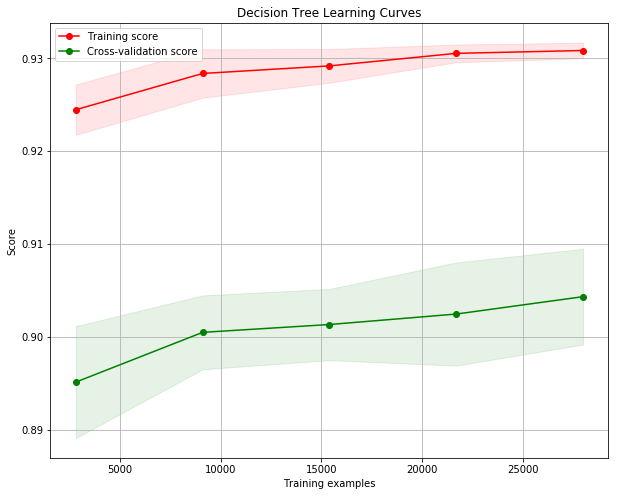

In [25]:
dt_title = 'Decision Tree Learning Curves'
dt_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=24)
plot_learning_curve(dt_gs.best_estimator_, dt_title, x_train, y_train, cv=dt_cv, n_jobs=4, figsize=(10,8))

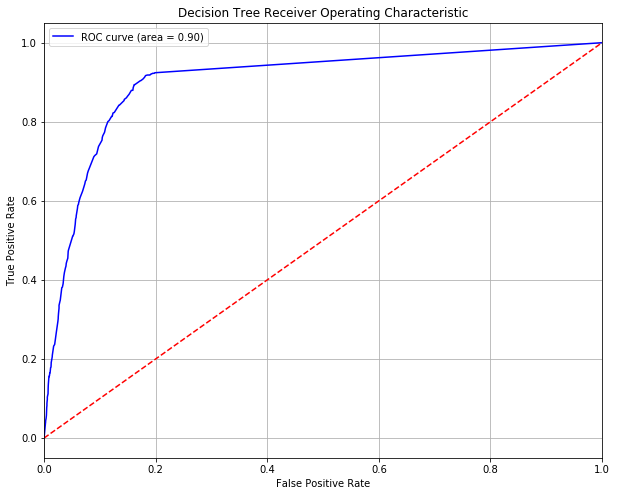

In [26]:
plot_roc_curve('Decision Tree', y_test, dt_gs.best_estimator_.predict_proba(x_test)[:, 1])

In [27]:
confusion_matrix(y_test, dt_gs.predict(x_test))

array([[5243,  239],
       [ 366,  331]], dtype=int64)

In [32]:
accuracy_score(y_test, dt_gs.predict(x_test))

0.9020877164589739

In [33]:
precision_score(y_test, dt_gs.predict(x_test))

0.5807017543859649

In [34]:
recall_score(y_test, dt_gs.predict(x_test))

0.4748923959827834

In [35]:
f1_score(y_test, dt_gs.predict(x_test))

0.5224940805051302

# SVM

In [16]:
svm = SVC(random_state=24, gamma='scale')

In [17]:
svm_params = [{'kernel': ['linear', 'rbf'],
               'C': [1.0, 0.75, 0.5],
               'shrinking': [True, False]},
              {'kernel': ['sigmoid'],
               'C': [1.0, 0.75, 0.5],
               'coef0': [0.0, 0.1, 0.25],
               'shrinking': [True, False]}]

In [18]:
svm_gs = GridSearchCV(svm, svm_params, cv=3, verbose=True, return_train_score=True, scoring='accuracy', n_jobs=4)

In [19]:
svm_gs.fit(x_train, y_train.values.reshape(-1))  

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 33.3min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed: 43.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=24, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'kernel': ['linear', 'rbf'], 'C': [1.0, 0.75, 0.5], 'shrinking': [True, False]}, {'kernel': ['sigmoid'], 'C': [1.0, 0.75, 0.5], 'coef0': [0.0, 0.1, 0.25], 'shrinking': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [20]:
svm_gs.best_params_

{'C': 0.75, 'kernel': 'rbf', 'shrinking': True}

In [21]:
joblib.dump(svm_gs, 'svm_gs.joblib')

['svm_gs.joblib']

<module 'matplotlib.pyplot' from 'C:\\Users\\Trace\\Anaconda3\\envs\\supervised\\lib\\site-packages\\matplotlib\\pyplot.py'>

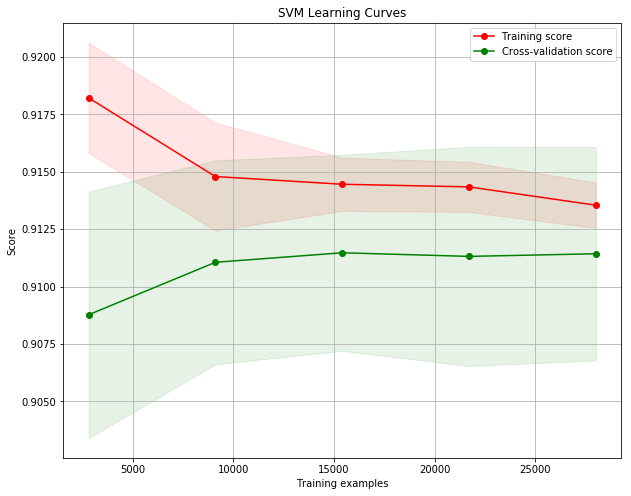

In [22]:
svm_title = 'SVM Learning Curves'
svm_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=24)
plot_learning_curve(svm_gs.best_estimator_, svm_title, x_train, y_train.values.reshape(-1), cv=svm_cv, n_jobs=4, figsize=(10,8))

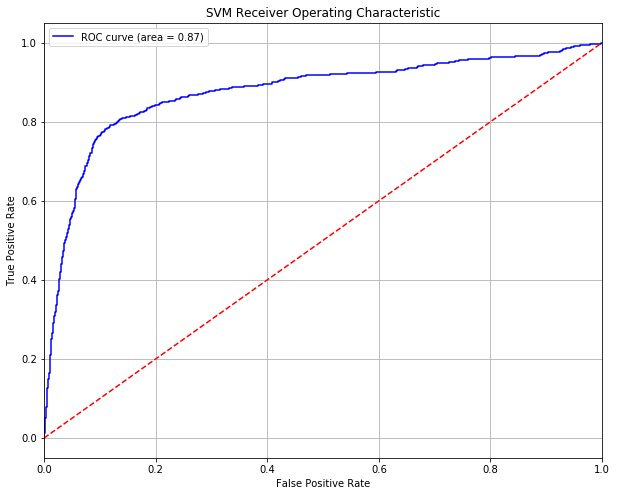

In [23]:
plot_roc_curve('SVM', y_test, svm_gs.best_estimator_.decision_function(x_test))

In [24]:
confusion_matrix(y_test, svm_gs.predict(x_test))

array([[5307,  175],
       [ 388,  309]], dtype=int64)

In [25]:
accuracy_score(y_test, svm_gs.predict(x_test))

0.9088849328370286

In [26]:
precision_score(y_test, svm_gs.predict(x_test))

0.6384297520661157

In [27]:
recall_score(y_test, svm_gs.predict(x_test))

0.4433285509325681

In [28]:
f1_score(y_test, svm_gs.predict(x_test))

0.5232853513971211

# KNN

In [16]:
knn = KNeighborsClassifier()

In [17]:
knn_params = {'n_neighbors': [3, 5, 7],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2, 3]}

In [18]:
knn_gs = GridSearchCV(knn, knn_params, cv=3, verbose=True, return_train_score=True, scoring='accuracy', n_jobs=4)

In [19]:
knn_gs.fit(x_train, y_train.values.reshape(-1))

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 162 out of 162 | elapsed: 59.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [20]:
knn_gs.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 3, 'weights': 'uniform'}

In [21]:
joblib.dump(knn, 'knn_gs.joblib')

['knn_gs.joblib']

<module 'matplotlib.pyplot' from 'C:\\Users\\Trace\\Anaconda3\\envs\\supervised\\lib\\site-packages\\matplotlib\\pyplot.py'>

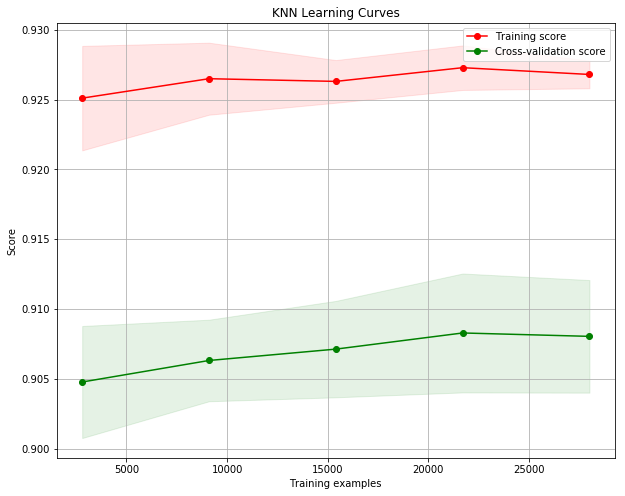

In [22]:
knn_title = 'KNN Learning Curves'
knn_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=24)
plot_learning_curve(knn_gs.best_estimator_, knn_title, x_train, y_train.values.reshape(-1), cv=knn_cv, n_jobs=4, figsize=(10,8))

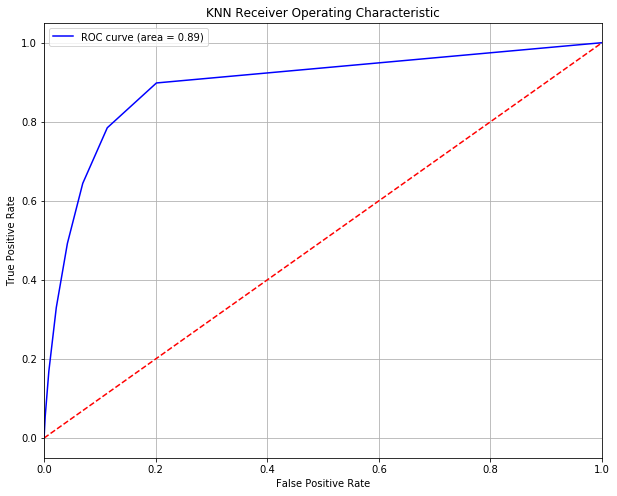

In [23]:
plot_roc_curve('KNN', y_test, knn_gs.best_estimator_.predict_proba(x_test)[:, 1])

In [24]:
y_pred = knn_gs.predict(x_test)

In [25]:
confusion_matrix(y_test, y_pred)

array([[5253,  229],
       [ 354,  343]], dtype=int64)

In [26]:
accuracy_score(y_test, y_pred)

0.9056481631331931

In [27]:
precision_score(y_test, y_pred)

0.5996503496503497

In [28]:
recall_score(y_test, y_pred)

0.4921090387374462

In [29]:
f1_score(y_test, y_pred)

0.5405831363278173

# ANN

In [16]:
ann = MLPClassifier(max_iter=1000)

In [17]:
ann_params = {'hidden_layer_sizes': list(itertools.combinations_with_replacement([2**i for i in range(3, 8)], 2)),
              'activation': ['logistic', 'tanh', 'relu'],
              'learning_rate': ['constant', 'invscaling', 'adaptive'],
              'solver': ['sgd', 'adam']}

In [18]:
#standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

In [19]:
ann_gs = GridSearchCV(ann, ann_params, cv=3, verbose=True, return_train_score=True, scoring='accuracy', n_jobs=4)

In [20]:
ann_gs.fit(min_max_scaler.fit_transform(x_train), y_train.values.reshape(-1))

C:\Users\Trace\Anaconda3\envs\supervised\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 12.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 52.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 102.3min
[Parallel(n_jobs=4)]: Done 810 out of 810 | elapsed: 108.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'hidden_layer_sizes': [(8, 8), (8, 16), (8, 32), (8, 64), (8, 128), (16, 16), (16, 32), (16, 64), (16, 128), (32, 32), (32, 64), (32, 128), (64, 64), (64, 128), (128, 128)], 'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'solver': ['sgd', 'adam']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=Tr

In [21]:
ann_gs.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (8, 32),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [22]:
joblib.dump(ann_gs, 'ann_gs.joblib')

['ann_gs.joblib']

C:\Users\Trace\Anaconda3\envs\supervised\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


<module 'matplotlib.pyplot' from 'C:\\Users\\Trace\\Anaconda3\\envs\\supervised\\lib\\site-packages\\matplotlib\\pyplot.py'>

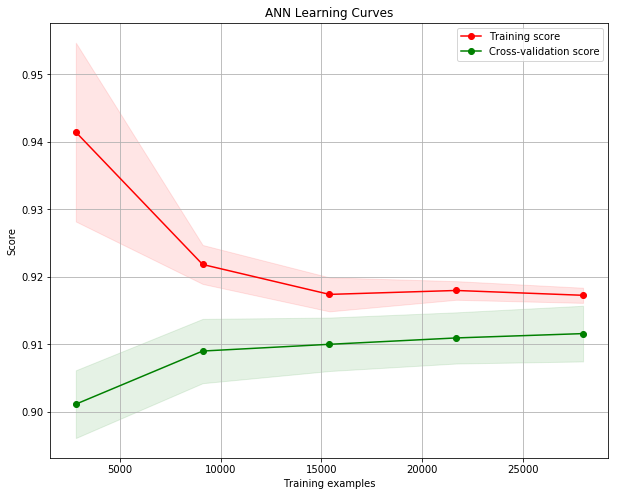

In [23]:
ann_title = 'ANN Learning Curves'
ann_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=24)
plot_learning_curve(ann_gs.best_estimator_, ann_title, min_max_scaler.fit_transform(x_train), y_train.values.reshape(-1), cv=ann_cv, n_jobs=4, figsize=(10,8))

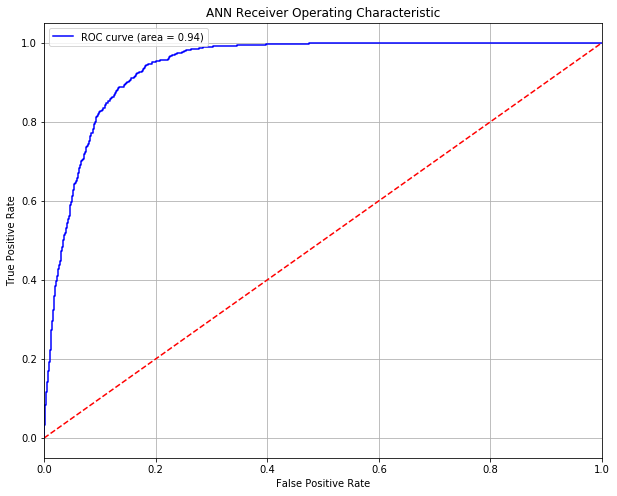

In [24]:
plot_roc_curve('ANN', y_test, ann_gs.best_estimator_.predict_proba(min_max_scaler.transform(x_test))[:, 1])

In [32]:
y_pred = ann_gs.predict(min_max_scaler.transform(x_test))

In [33]:
confusion_matrix(y_test, y_pred)

array([[5275,  207],
       [ 336,  361]], dtype=int64)

In [34]:
accuracy_score(y_test, y_pred)

0.9121217025408642

In [35]:
precision_score(y_test, y_pred)

0.6355633802816901

In [36]:
recall_score(y_test, y_pred)

0.5179340028694405

In [37]:
f1_score(y_test, y_pred)

0.5707509881422925

# Boosting

In [46]:
bst = GradientBoostingClassifier()

In [49]:
bst_params = {'loss': ['deviance', 'exponential'],
              'n_estimators': [50, 100, 500, 1000],
              'subsample': [0.5, 0.75, 1.],
              'min_samples_split': [2, 5, 10]}

In [50]:
bst_gs = GridSearchCV(bst, bst_params, cv=3, verbose=True, return_train_score=True, scoring='accuracy', n_jobs=4)

In [51]:
bst_gs.fit(x_train, y_train.values.reshape(-1))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed: 11.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'loss': ['deviance', 'exponential'], 'n_estimators': [50, 100, 500, 1000], 'subsample': [0.5, 0.75, 1.0], 'min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [52]:
bst_gs.best_params_

{'loss': 'deviance',
 'min_samples_split': 5,
 'n_estimators': 100,
 'subsample': 0.5}

In [53]:
joblib.dump(bst_gs, 'bst_gs.joblib')

['bst_gs.joblib']

<module 'matplotlib.pyplot' from 'C:\\Users\\Trace\\Anaconda3\\envs\\supervised\\lib\\site-packages\\matplotlib\\pyplot.py'>

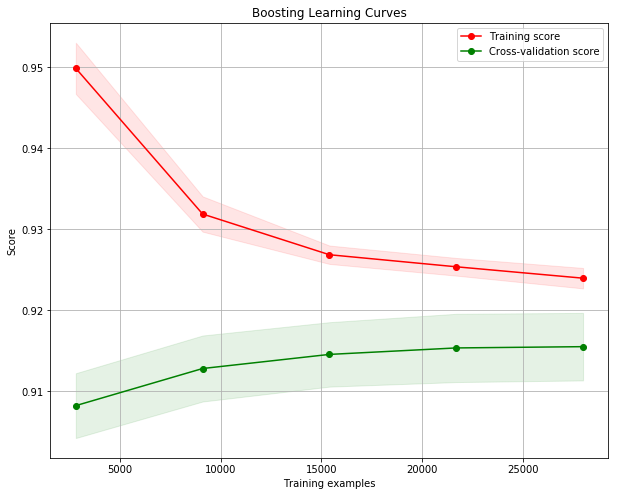

In [54]:
bst_title = 'Boosting Learning Curves'
bst_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=24)
plot_learning_curve(bst_gs.best_estimator_, bst_title, x_train, y_train.values.reshape(-1), cv=bst_cv, n_jobs=4, figsize=(10,8))

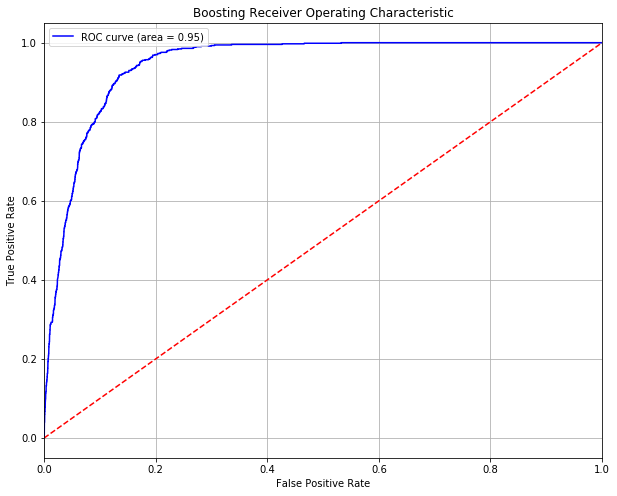

In [55]:
plot_roc_curve('Boosting', y_test, bst_gs.best_estimator_.decision_function(x_test))

In [56]:
y_pred = bst_gs.predict(x_test)

In [57]:
confusion_matrix(y_test, y_pred)

array([[5261,  221],
       [ 309,  388]], dtype=int64)

In [58]:
accuracy_score(y_test, y_pred)

0.9142256028483573

In [59]:
precision_score(y_test, y_pred)

0.6371100164203612

In [60]:
recall_score(y_test, y_pred)

0.5566714490674318

In [61]:
f1_score(y_test, y_pred)

0.5941807044410412